In [1]:
require 'paths'
if (not paths.filep("cifar10torchsmall.zip")) then
    os.execute('wget -c https://s3.amazonaws.com/torch7/data/cifar10torchsmall.zip')
    os.execute('unzip cifar10torchsmall.zip')
end
trainset = torch.load('cifar10-train.t7')
testset = torch.load('cifar10-test.t7')
classes = {'airplane', 'automobile', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck'}

In [2]:
print(trainset)

{
  data : ByteTensor - size: 10000x3x32x32
  label : ByteTensor - size: 10000
}


In [3]:
print(#trainset.data)

 10000
     3
    32
    32
[torch.LongStorage of size 4]



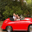

automobile	


In [4]:
itorch.image(trainset.data[100]) -- display the 100-th image in dataset
print(classes[trainset.label[100]])

In [5]:
-- ignore setmetatable for now, it is a feature beyond the scope of this tutorial. It sets the index operator.
setmetatable(trainset, 
    {__index = function(t, i) 
                    return {t.data[i], t.label[i]} 
                end}
);
trainset.data = trainset.data:double() -- convert the data from a ByteTensor to a DoubleTensor.

function trainset:size() 
    return self.data:size(1) 
end

In [6]:
print(trainset:size()) -- just to test

10000	


{
  1 : DoubleTensor - size: 3x32x32
  2 : 2
}


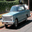

In [7]:
print(trainset[33]) -- load sample number 33.
itorch.image(trainset[33][1])

In [8]:
redChannel = trainset.data[{ {}, {1}, {}, {}  }] -- this picks {all images, 1st channel, all vertical pixels, all horizontal pixels}

In [9]:
print(#redChannel)

 10000
     1
    32
    32
[torch.LongStorage of size 4]



In [10]:
mean = {} -- store the mean, to normalize the test set in the future
stdv  = {} -- store the standard-deviation for the future
for i=1,3 do -- over each image channel
    mean[i] = trainset.data[{ {}, {i}, {}, {}  }]:mean() -- mean estimation
    print('Channel ' .. i .. ', Mean: ' .. mean[i])
    trainset.data[{ {}, {i}, {}, {}  }]:add(-mean[i]) -- mean subtraction
    
    stdv[i] = trainset.data[{ {}, {i}, {}, {}  }]:std() -- std estimation
    print('Channel ' .. i .. ', Standard Deviation: ' .. stdv[i])
    trainset.data[{ {}, {i}, {}, {}  }]:div(stdv[i]) -- std scaling
end

Channel 1, Mean: 125.83175029297	


Channel 1, Standard Deviation: 63.143400842609	


Channel 2, Mean: 123.26066621094	


Channel 2, Standard Deviation: 62.369209019002	


Channel 3, Mean: 114.03068681641	


Channel 3, Standard Deviation: 66.965808411114	


In [16]:
require 'nn';
net = nn.Sequential()
net:add(nn.SpatialConvolution(3, 6, 5, 5)) -- 3 input image channels, 6 output channels, 5x5 convolution kernel
net:add(nn.ReLU())                       -- non-linearity 
net:add(nn.SpatialMaxPooling(2,2,2,2))     -- A max-pooling operation that looks at 2x2 windows and finds the max.
net:add(nn.SpatialConvolution(6, 16, 5, 5))
net:add(nn.ReLU())                       -- non-linearity 
net:add(nn.SpatialMaxPooling(2,2,2,2))
net:add(nn.View(16*5*5))                    -- reshapes from a 3D tensor of 16x5x5 into 1D tensor of 16*5*5
net:add(nn.Linear(16*5*5, 120))             -- fully connected layer (matrix multiplication between input and weights)
net:add(nn.ReLU())                       -- non-linearity 
net:add(nn.Linear(120, 84))
net:add(nn.ReLU())                       -- non-linearity 
net:add(nn.Linear(84, 10))                   -- 10 is the number of outputs of the network (in this case, 10 digits)
net:add(nn.LogSoftMax())                     -- converts the output to a log-probability. Useful for classification problems

In [17]:
criterion = nn.ClassNLLCriterion()

horse	


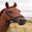

In [18]:
print(classes[testset.label[100]])
itorch.image(testset.data[100])

In [19]:
testset.data = testset.data:double()   -- convert from Byte tensor to Double tensor
for i=1,3 do -- over each image channel
    testset.data[{ {}, {i}, {}, {}  }]:add(-mean[i]) -- mean subtraction    
    testset.data[{ {}, {i}, {}, {}  }]:div(stdv[i]) -- std scaling
end

In [20]:
-- for fun, print the mean and standard-deviation of example-100
horse = testset.data[100]
print(horse:mean(), horse:std())

0.59066009532189	1.0665356205025	


horse	


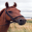

In [21]:
print(classes[testset.label[100]])
itorch.image(testset.data[100])
predicted = net:forward(testset.data[100])

In [22]:
-- the output of the network is Log-Probabilities. To convert them to probabilities, you have to take e^x 
print(predicted:exp())

 0.1029
 0.0998
 0.0957
 0.1069
 0.1055
 0.1025
 0.1004
 0.1002
 0.0932
 0.0928
[torch.DoubleTensor of size 10]




In [23]:
for i=1,predicted:size(1) do
    print(classes[i], predicted[i])
end

airplane	0.10288838746855	
automobile	0.099772383499422	
bird	0.095738617731678	
cat	0.10691436842109	
deer	0.1054968770697	
dog	0.10246742447046	
frog	0.10044704717764	
horse	0.10020444170214	
ship	0.093242264103206	
truck	0.092828188332701	


In [24]:
correct = 0
for i=1,10000 do
    local groundtruth = testset.label[i]
    local prediction = net:forward(testset.data[i])
    local confidences, indices = torch.sort(prediction, true)  -- true means sort in descending order
    if groundtruth == indices[1] then
        correct = correct + 1
    end
end

In [25]:
print(correct, 100*correct/10000 .. ' % ')

1046	10.46 % 	


In [26]:
class_performance = {0, 0, 0, 0, 0, 0, 0, 0, 0, 0}
for i=1,10000 do
    local groundtruth = testset.label[i]
    local prediction = net:forward(testset.data[i])
    local confidences, indices = torch.sort(prediction, true)  -- true means sort in descending order
    if groundtruth == indices[1] then
        class_performance[groundtruth] = class_performance[groundtruth] + 1
    end
end

In [27]:
for i=1,#classes do
    print(classes[i], 100*class_performance[i]/1000 .. ' %')
end

airplane	0 %	
automobile	0 %	
bird	0 %	
cat	76.4 %	
deer	27.7 %	
dog	0.5 %	
frog	0 %	
horse	0 %	
ship	0 %	
truck	0 %	


In [30]:
require 'cunn';

[string "require 'cunn';..."]:1: module 'cunn' not found:
	no field package.preload['cunn']
	no file '/Users/jm/.luarocks/share/lua/5.1/cunn.lua'
	no file '/Users/jm/.luarocks/share/lua/5.1/cunn/init.lua'
	no file '/Users/jm/torch/install/share/lua/5.1/cunn.lua'
	no file '/Users/jm/torch/install/share/lua/5.1/cunn/init.lua'
	no file './cunn.lua'
	no file '/Users/jm/torch/insta$'
	no file '/Users/jm/torch/install/lib/cunn.dylib'
	no file ''/Users/jm/.luarocks/lib/lua/5.1/cunn.so'
	no file '/Users/jm/torch/install/lib/lua/5.1/cunn.so'
	no file './cunn.so'
	no file '/usr/local/lib/lua/5.1/cunn.so'
	no file '/usr/local/lib/lua/5.1/loadall.so'
stack traceback:
	[C]: in function 'require'
	[string "require 'cunn';..."]:1: in main chunk
	[C]: in function 'xpcall'
	/Users/jm/torch/install/share/lua/5.1/itorch/main.lua:209: in function </Users/jm/torch/install/share/lua/5.1/itorch/main.lua:173>
	/Users/jm/torch/install/share/lua/5.1/lzmq/poller.lua:75: in function 'poll'
	/Users/jm/torch/install/share/lua/5.1/lzmq/impl/loop.lua:307: in function 'poll'
	/Users/jm/torch/install/share/lua/5.1/lzmq/impl/loop.lua:325: in function 'sleep_ex'
	/Users/jm/torch/install/share/lua/5.1/lzmq/impl/loop.lua:370: in function 'start'
	/Users/jm/torch/install/share/lua/5.1/itorch/main.lua:381: in main chunk
	[C]: in function 'require'
	(command line):1: in main chunk
	[C]: at 0x0105427d20: 

In [31]:
net = net:cuda()

/Users/jm/torch/install/share/lua/5.1/torch/Tensor.lua:238: attempt to index a nil value
stack traceback:
	/Users/jm/torch/install/share/lua/5.1/torch/Tensor.lua:238: in function 'type'
	/Users/jm/torch/install/share/lua/5.1/nn/utils.lua:52: in function 'recursiveType'
	/Users/jm/torch/install/share/lua/5.1/nn/Module.lua:126: in function 'cuda'
	[string "net = net:cuda()..."]:1: in main chunk
	[C]: in function 'xpcall'
	/Users/jm/torch/install/share/lua/5.1/itorch/main.lua:209: in function </Users/jm/torch/install/share/lua/5.1/itorch/main.lua:173>
	/Users/jm/torch/install/share/lua/5.1/lzmq/poller.lua:75: in function 'poll'
	/Users/jm/torch/install/share/lua/5.1/lzmq/impl/loop.lua:307: in function 'poll'
	/Users/jm/torch/install/share/lua/5.1/lzmq/impl/loop.lua:325: in function 'sleep_ex'
	/Users/jm/torch/install/share/lua/5.1/lzmq/impl/loop.lua:370: in function 'start'
	/Users/jm/torch/install/share/lua/5.1/itorch/main.lua:381: in main chunk
	[C]: in function 'require'
	(command line):1: in main chunk
	[C]: at 0x0105427d20: 

In [32]:
criterion = criterion:cuda()

/Users/jm/torch/install/share/lua/5.1/torch/Tensor.lua:238: attempt to index a nil value
stack traceback:
	/Users/jm/torch/install/share/lua/5.1/torch/Tensor.lua:238: in function 'type'
	/Users/jm/torch/install/share/lua/5.1/nn/utils.lua:52: in function 'recursiveType'
	/Users/jm/torch/install/share/lua/5.1/nn/Criterion.lua:35: in function 'cuda'
	[string "criterion = criterion:cuda()..."]:1: in main chunk
	[C]: in function 'xpcall'
	/Users/jm/torch/install/share/lua/5.1/itorch/main.lua:209: in function </Users/jm/torch/install/share/lua/5.1/itorch/main.lua:173>
	/Users/jm/torch/install/share/lua/5.1/lzmq/poller.lua:75: in function 'poll'
	/Users/jm/torch/install/share/lua/5.1/lzmq/impl/loop.lua:307: in function 'poll'
	/Users/jm/torch/install/share/lua/5.1/lzmq/impl/loop.lua:325: in function 'sleep_ex'
	/Users/jm/torch/install/share/lua/5.1/lzmq/impl/loop.lua:370: in function 'start'
	/Users/jm/torch/install/share/lua/5.1/itorch/main.lua:381: in main chunk
	[C]: in function 'require'
	(command line):1: in main chunk
	[C]: at 0x0105427d20: 

In [33]:
trainset.data = trainset.data:cuda()
trainset.label = trainset.label:cuda()

[string "trainset.data = trainset.data:cuda()..."]:1: attempt to call method 'cuda' (a nil value)
stack traceback:
	[string "trainset.data = trainset.data:cuda()..."]:1: in main chunk
	[C]: in function 'xpcall'
	/Users/jm/torch/install/share/lua/5.1/itorch/main.lua:209: in function </Users/jm/torch/install/share/lua/5.1/itorch/main.lua:173>
	/Users/jm/torch/install/share/lua/5.1/lzmq/poller.lua:75: in function 'poll'
	/Users/jm/torch/install/share/lua/5.1/lzmq/impl/loop.lua:307: in function 'poll'
	/Users/jm/torch/install/share/lua/5.1/lzmq/impl/loop.lua:325: in function 'sleep_ex'
	/Users/jm/torch/install/share/lua/5.1/lzmq/impl/loop.lua:370: in function 'start'
	/Users/jm/torch/install/share/lua/5.1/itorch/main.lua:381: in main chunk
	[C]: in function 'require'
	(command line):1: in main chunk
	[C]: at 0x0105427d20: 

In [34]:
trainer = nn.StochasticGradient(net, criterion)
trainer.learningRate = 0.001
trainer.maxIteration = 5 -- just do 5 epochs of training.

In [35]:
trainer:train(trainset)

# StochasticGradient: training	


# current error = 2.2028128739621	


# current error = 1.8976353348807	


# current error = 1.6831710786534	


# current error = 1.5794372353015	


# current error = 1.4978048716147	
# StochasticGradient: you have reached the maximum number of iterations	
# training error = 1.4978048716147	

